In [1]:
%pip install opencv-python scikit-image

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report)
from skimage.feature import hog, local_binary_pattern
import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_dataset(dataset_path, img_size=(128, 128)):
    dataset_path = Path(dataset_path)
    images = []
    labels = []
    class_names = []
    
    for class_folder in sorted(dataset_path.iterdir()):
        if class_folder.is_dir():
            class_name = class_folder.name
            class_names.append(class_name)
            print(f"Loading class: {class_name}")
            
            count = 0
            for img_path in class_folder.glob("*.png"):
                img = cv2.imread(str(img_path))
                if img is not None:
                    img_resized = cv2.resize(img, img_size)
                    images.append(img_resized)
                    labels.append(class_name)
                    count += 1
            print(f"  → Loaded {count} images")
    
    print(f"\nTotal images loaded: {len(images)}")
    print(f"Classes: {class_names}")
    print(f"Class distribution:")
    for class_name in class_names:
        count = labels.count(class_name)
        print(f"  - {class_name}: {count} images")
    
    return np.array(images), np.array(labels), class_names

In [4]:
DATASET_PATH = r"C:\Users\LENOVO\OneDrive\Documents\KULLYEAH\Semester 3\Artificial Intelligence\Project KA\Brain_Stroke_CT_Dataset"
images, labels, class_names = load_dataset(DATASET_PATH)

Loading class: Bleeding
  → Loaded 1093 images
Loading class: Ischemia
  → Loaded 1130 images
Loading class: Normal
  → Loaded 4427 images

Total images loaded: 6650
Classes: ['Bleeding', 'Ischemia', 'Normal']
Class distribution:
  - Bleeding: 1093 images
  - Ischemia: 1130 images
  - Normal: 4427 images


In [5]:
def preprocess_images(images):
    images_gray = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images_gray.append(gray)
    
    print(f"Converted {len(images_gray)} images to grayscale")
    print(f"Image shape: {images_gray[0].shape}")
    
    return np.array(images_gray)

In [6]:
images_gray = preprocess_images(images)

Converted 6650 images to grayscale
Image shape: (128, 128)


In [7]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3),
                            range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.append(hist)
    return np.array(lbp_features)

def extract_color_histogram(images_color):
    hist_features = []
    for img in images_color:
        hist = []
        for i in range(3):
            channel_hist = cv2.calcHist([img], [i], None, [32], [0, 256])
            channel_hist = channel_hist.flatten()
            hist.extend(channel_hist)
        hist_features.append(hist)
    return np.array(hist_features)

In [8]:
def extract_all_features(images_color, images_gray):
    print("Extracting HOG features...")
    hog_features = extract_hog_features(images_gray)
    print(f"  → HOG shape: {hog_features.shape}")
    
    print("Extracting LBP features...")
    lbp_features = extract_lbp_features(images_gray)
    print(f"  → LBP shape: {lbp_features.shape}")
    
    print("Extracting Color Histogram features...")
    hist_features = extract_color_histogram(images_color)
    print(f"  → Color Hist shape: {hist_features.shape}")
    
    combined_features = np.hstack([hog_features, lbp_features, hist_features])
    print(f"\nCombined features shape: {combined_features.shape}")
    
    return combined_features, hog_features, lbp_features, hist_features

In [9]:
combined_features, hog_feat, lbp_feat, hist_feat = extract_all_features(images, images_gray)

Extracting HOG features...
  → HOG shape: (6650, 8100)
Extracting LBP features...
  → LBP shape: (6650, 26)
Extracting Color Histogram features...
  → Color Hist shape: (6650, 96)

Combined features shape: (6650, 8222)


In [10]:
def normalize_features(hog_feat, lbp_feat, hist_feat):
    scaler_standard = StandardScaler()
    hog_normalized = scaler_standard.fit_transform(hog_feat)
    lbp_normalized = scaler_standard.fit_transform(lbp_feat)
    
    scaler_minmax = MinMaxScaler()
    hist_normalized = scaler_minmax.fit_transform(hist_feat)
    
    normalized_features = np.hstack([hog_normalized, lbp_normalized, hist_normalized])
    
    print(f"HOG normalized: {hog_normalized.shape}")
    print(f"LBP normalized: {lbp_normalized.shape}")
    print(f"Histogram normalized: {hist_normalized.shape}")
    print(f"Combined normalized features: {normalized_features.shape}")
    
    scalers = {
        'standard': scaler_standard,
        'minmax': scaler_minmax
    }
    
    return normalized_features, scalers

In [11]:
normalized_features, scalers = normalize_features(hog_feat, lbp_feat, hist_feat)

HOG normalized: (6650, 8100)
LBP normalized: (6650, 26)
Histogram normalized: (6650, 96)
Combined normalized features: (6650, 8222)


In [12]:
def apply_pca(features, n_components=200):
    n_components = min(n_components, features.shape[1], features.shape[0])
    
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    
    explained_variance = np.sum(pca.explained_variance_ratio_)
    
    print(f"Original features: {features.shape}")
    print(f"PCA features: {features_pca.shape}")
    print(f"Explained variance: {explained_variance:.4f} ({explained_variance*100:.2f}%)")
    
    return features_pca, pca

In [13]:
use_pca = True
n_components = 300

if use_pca:
    final_features, pca = apply_pca(normalized_features, n_components)
else:
    final_features = normalized_features
    pca = None
    print("\n[INFO] Skipping PCA - Using normalized features directly")

Original features: (6650, 8222)
PCA features: (6650, 300)
Explained variance: 0.6497 (64.97%)


In [14]:
def split_data(features, labels, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Split ratio: {(1-test_size)*100:.0f}% / {test_size*100:.0f}%")
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = split_data(final_features, labels)

Training set: 5320 samples
Testing set: 1330 samples
Split ratio: 80% / 20%


In [16]:
def train_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    knn = KNeighborsClassifier()
    
    print("Running Grid Search with 5-fold Cross Validation...")
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', 
                            n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  - {param}: {value}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    
    return best_model, best_params

In [17]:
knn_model, best_params = train_knn(X_train, y_train)

Running Grid Search with 5-fold Cross Validation...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters:
  - metric: euclidean
  - n_neighbors: 3
  - weights: distance
Best CV Score: 0.9237


In [18]:
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1-Score : {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'y_true': y_test,
        'y_pred': y_pred
    }
    
    return metrics

In [19]:
metrics = evaluate_model(knn_model, X_test, y_test, class_names)


Overall Metrics:
  Accuracy : 0.9496
  Precision: 0.9494
  Recall   : 0.9496
  F1-Score : 0.9493
Classification Report:
              precision    recall  f1-score   support

    Bleeding       0.94      0.88      0.91       219
    Ischemia       0.92      0.92      0.92       226
      Normal       0.96      0.97      0.97       885

    accuracy                           0.95      1330
   macro avg       0.94      0.93      0.93      1330
weighted avg       0.95      0.95      0.95      1330



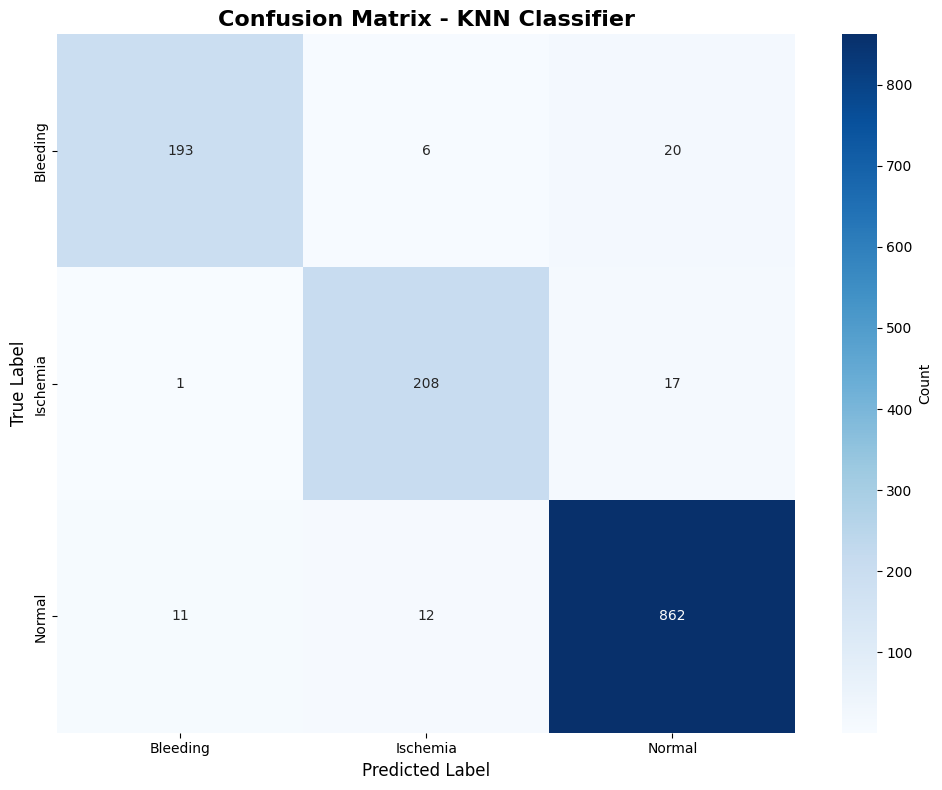

In [20]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - KNN Classifier', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(metrics['confusion_matrix'], class_names)

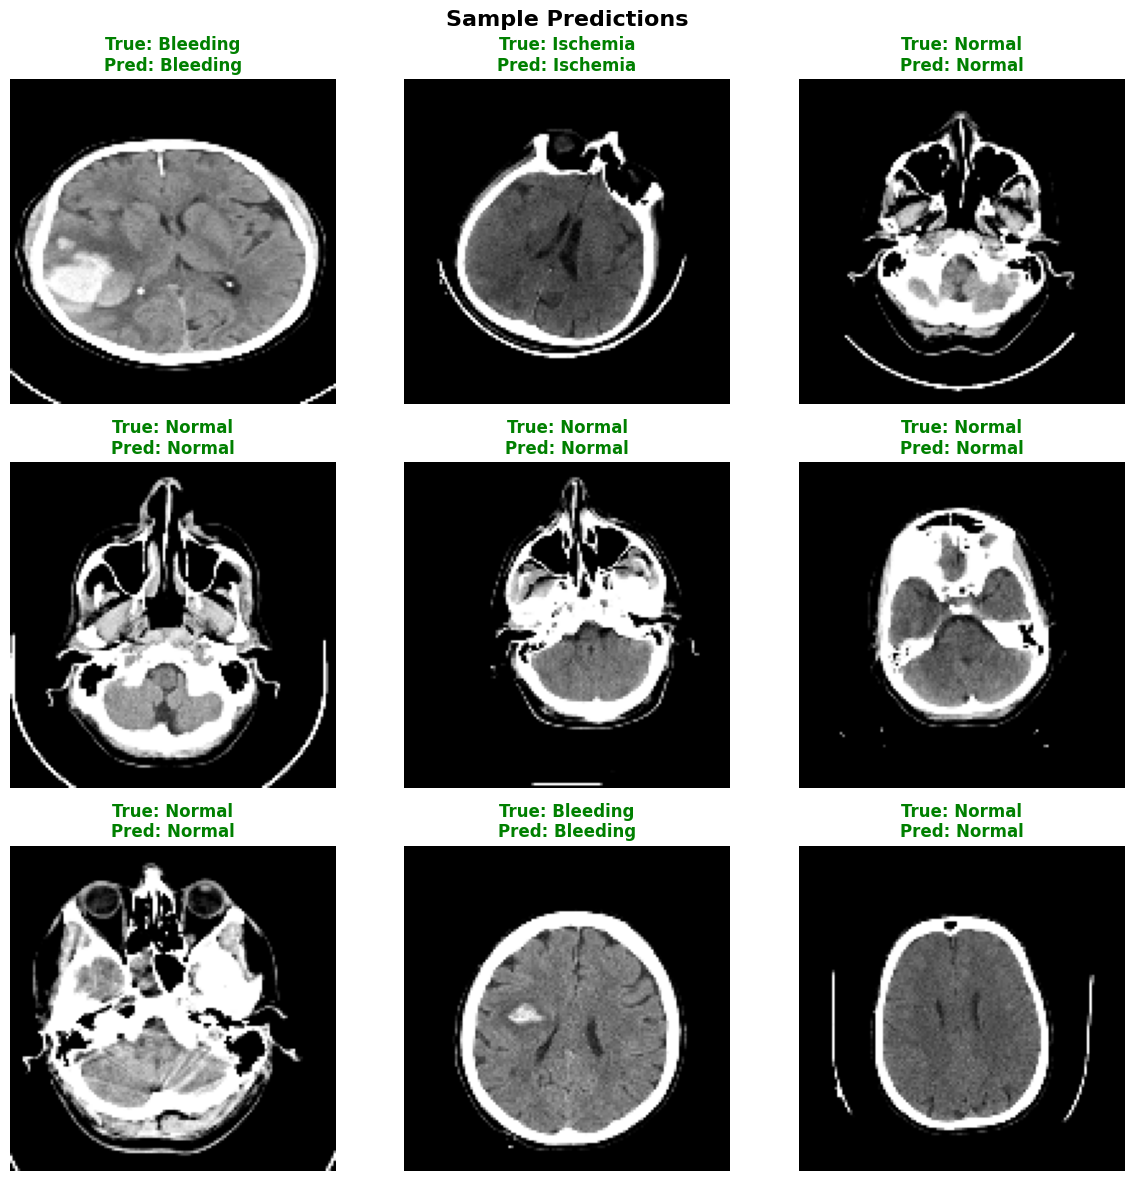

In [21]:
def plot_sample_predictions(images, y_true, y_pred, class_names, n_samples=9):
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for idx, ax in enumerate(axes):
        if idx < len(indices):
            i = indices[idx]
            img = images[i]
            true_label = y_true[i]
            pred_label = y_pred[i]
            
            if len(img.shape) == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap='gray')
            
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label}', 
                        color=color, fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle('Sample Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

_, X_test_full, _, y_test_full = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

plot_sample_predictions(X_test_full, metrics['y_true'], metrics['y_pred'], class_names)

In [22]:
print(f"Final Model: K-Nearest Neighbors (KNN)")
print(f"Best Parameters: {best_params}")
print(f"Test Accuracy: {metrics['accuracy']:.4f}")
print(f"Test F1-Score: {metrics['f1_score']:.4f}")

Final Model: K-Nearest Neighbors (KNN)
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Test Accuracy: 0.9496
Test F1-Score: 0.9493


In [23]:
results = {
    'model': knn_model,
    'scalers': scalers,
    'pca': pca if use_pca else None,
    'metrics': metrics,
    'class_names': class_names,
    'best_params': best_params
}

In [24]:
all_features = np.hstack([hog_feat, lbp_feat, hist_feat])
df_features = pd.DataFrame(all_features)
df_features['Label'] = labels
output_csv_path = "extracted_features.csv"
df_features.to_csv(output_csv_path, index=False)